In [1]:
import os

os.environ['CUDA_VISIBLE_DEVICES'] = '1'

In [2]:
import sys

SOURCE_DIR = os.path.dirname(os.path.dirname(os.path.abspath(__name__)))
sys.path.insert(0, SOURCE_DIR)

In [3]:
import malaya_speech
import tensorflow as tf
from malaya_speech.train.model import fastsplit, fastspeech
import malaya_speech.augmentation.waveform as augmentation
import numpy as np






The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



In [4]:
from glob import glob

wavs = glob('../speech/example-speaker/*.wav')
len(wavs)

8

In [5]:
import random

sr = 22050
speakers_size = 4

# noise = malaya_speech.load('noise.wav', sr = sr)[0]

def read_wav(f):
    return malaya_speech.load(f, sr = sr)


def random_sampling(s, length):
    return augmentation.random_sampling(s, sr = sr, length = length)

def to_mel(y):
    mel = malaya_speech.featurization.universal_mel(y)
    mel[mel <= np.log(1e-2)] = np.log(1e-2)
    return mel

def combine_speakers(files, n = 5, limit = 4):
    w_samples = random.sample(files, n)
    w_samples = [read_wav(f)[0] for f in w_samples]
    w_lens = [len(w) / sr for w in w_samples]
    w_lens = int(min(min(w_lens) * 1000, random.randint(2000, 10000)))
    w_samples = [random_sampling(w, length = w_lens) for w in w_samples]
    y = [w_samples[0]]
    left = w_samples[0].copy() * random.uniform(0.5, 1.0)

    combined = None

    for i in range(1, n):
        right = w_samples[i].copy() * random.uniform(0.5, 1.0)
        overlap = random.uniform(0.98, 1.0)
        print(i, overlap)
        len_overlap = int(overlap * len(right))
        minus = len(left) - len_overlap
        if minus < 0:
            minus = 0
        padded_right = np.pad(right, (minus, 0))
        left = np.pad(left, (0, len(padded_right) - len(left)))

        left = left + padded_right

        if i >= (limit - 1):
            if combined is None:
                combined = padded_right
            else:
                combined = np.pad(
                    combined, (0, len(padded_right) - len(combined))
                )
                combined += padded_right

        else:
            y.append(padded_right)

    if combined is not None:
        y.append(combined)

    for i in range(len(y)):
        if len(y[i]) != len(left):
            y[i] = np.pad(y[i], (0, len(left) - len(y[i])))
            y[i] = y[i] / np.max(np.abs(y[i]))

    left = left / np.max(np.abs(left))
    return left, y

# y, _ = malaya_speech.load('../speech/example-speaker/husein-zolkepli.wav')
# y = np.expand_dims(y, 0).astype(np.float32)
# y.shape

In [6]:
left, y = combine_speakers(wavs, 6)
len(left) / sr, len(y)

1 0.9973001911773604
2 0.9829406675040097
3 0.9822246286987242
4 0.9945504804294524
5 0.9840144793310416


(3.0451700680272107, 4)

In [7]:
left_mel = malaya_speech.featurization.universal_mel(left)
y_mel = [malaya_speech.featurization.universal_mel(i) for i in y]

In [8]:
config = malaya_speech.config.fastspeech_config
dim = 192
config['encoder_hidden_size'] = dim * speakers_size
config['decoder_hidden_size'] = dim * speakers_size
config = fastspeech.Config(vocab_size = 1, **config)

In [9]:
model = fastsplit.Model(config, O = dim, C = speakers_size, masking = False)


Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [10]:
X = tf.placeholder(tf.float32, [None, None, 80])
Y = tf.placeholder(tf.float32, [None, speakers_size, None, 80])
lengths = tf.placeholder(tf.int32, [None])
outputs = model(X, lengths)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


In [11]:
outputs

<tf.Tensor 'fastvc/mel_before/BiasAdd:0' shape=(?, ?, 4, 80) dtype=float32>

In [12]:
loss, abs_set = fastsplit.calculate_loss(Y, outputs, lengths, C = speakers_size, return_set = True,
                                        method = tf.square)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



In [13]:
loss, abs_set

(<tf.Tensor 'Mean:0' shape=() dtype=float32>,
 <tf.Tensor 'einsum/Reshape_2:0' shape=(?, 24) dtype=float32>)

In [14]:
sess = tf.InteractiveSession()
sess.run(tf.global_variables_initializer())

In [15]:
%%time

o = sess.run(outputs, feed_dict = {X: [left_mel], lengths: [len(left_mel)]})
o.shape

CPU times: user 1.05 s, sys: 112 ms, total: 1.16 s
Wall time: 436 ms


(1, 263, 4, 80)

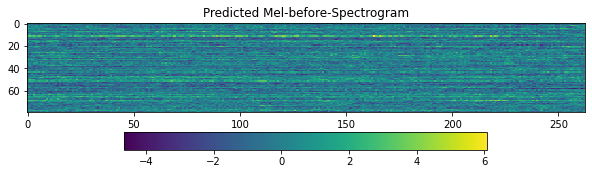

In [16]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(10, 8))
ax1 = fig.add_subplot(311)
ax1.set_title('Predicted Mel-before-Spectrogram')
im = ax1.imshow(np.rot90(o[0,:,3]), aspect='auto', interpolation='none')
fig.colorbar(mappable=im, shrink=0.65, orientation='horizontal', ax=ax1)
plt.show()

In [17]:
l = sess.run([loss, abs_set], feed_dict = {X: [left_mel], Y: [y_mel], lengths: [len(left_mel)]})
l[0], l[1].shape

(4.34891, (1, 24))

In [18]:
saver = tf.train.Saver()

In [19]:
saver.save(sess, 'test/model.ckpt')

'test/model.ckpt'

In [20]:
!ls -lh test

total 452128
-rw-r--r--  1 huseinzolkepli  staff    77B Mar 15 14:51 checkpoint
-rw-r--r--  1 huseinzolkepli  staff   185M Mar 15 14:51 model.ckpt.data-00000-of-00001
-rw-r--r--  1 huseinzolkepli  staff   5.5K Mar 15 14:51 model.ckpt.index
-rw-r--r--  1 huseinzolkepli  staff    25M Mar 15 14:51 model.ckpt.meta


In [21]:
!rm -rf test